In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import time

In [2]:
class BurgersPinn(keras.Model):
  def __init__(self, nu, network, n_inputs=2, n_outputs=1):
    super().__init__()
    self.network = network
    self.nu = nu
    self.n_inputs = n_inputs,
    self.n_outputs = n_outputs

  def fit(self, inputs, epochs, progress_interval=500, **kwargs):
    optimizer = keras.optimizers.SGD(learning_rate=0.001)
    start_time = time.time()
    for epoch in range(epochs):
      with tf.GradientTape() as tape:
        self.call(inputs, training=True)
        loss = tf.reduce_sum(self.losses)
        
      grads = tape.gradient(loss, self.trainable_weights)
      optimizer.apply_gradients(zip(grads, self.trainable_weights))
      if epoch % progress_interval == 0:
        print(f"Epoch: {epoch} Loss: {loss.numpy():.4f} Total Elapsed Time: {time.time() - start_time:.2f}")

  @tf.function
  def input_gradient(self, x):
      with tf.GradientTape() as g2tape: # grad tape for getting second order derivatives
        g2tape.watch(x) # gradients w.r.t. inputs
        with tf.GradientTape() as gtape: # grad tape for first order drivatives
          gtape.watch(x)
          u = self.network(x)
        
        first_order = gtape.batch_jacobian(u, x)
        u_t = first_order[..., 0]
        u_x = first_order[..., 1]
      
      u_xx = g2tape.batch_jacobian(u_x, x)[..., 1]
      return u, u_t, u_x, u_xx
  
  def call(self, inputs, training=True): 
    if training:
      tx_equation = inputs[0]
    else:
      tx_equation = inputs
    u, u_t, u_x, u_xx = self.input_gradient(tx_equation)
    burgers_eq = u_t + u*u_x - self.nu*u_xx
    self.add_loss(lambda: tf.reduce_mean(tf.square(burgers_eq)))

    if training:
      tx_init = inputs[1]
      tx_bound = inputs[2]
      n_i = tx_init.shape[0]
      u_ib = self.network(tf.concat([tx_init, tx_bound], axis = 0))

      self.add_loss(lambda: tf.reduce_mean(tf.square(u_ib[:n_i] - tf.sin(np.pi*tx_init[..., 1]))))
      self.add_loss(lambda: tf.reduce_mean(tf.square(u_ib[n_i:])))

      return burgers_eq

    return burgers_eq
  
  @staticmethod
  def build_network(layers, n_inputs=2, n_outputs=1, activation=keras.activations.tanh, initialization=keras.initializers.glorot_normal):
    inputs = keras.layers.Input((n_inputs))
    x = inputs
    for i in layers:
      x = keras.layers.Dense(i, activation = activation, kernel_initializer=initialization)(x)
    
    outputs = keras.layers.Dense(n_outputs, kernel_initializer=initialization)(x)
    return keras.Model(inputs=[inputs], outputs = [outputs])

  @staticmethod
  def simulate_burgers(n_samples, training = True, dtype=tf.float32, boundary_samples = None, random_seed = 42):
    r = np.random.RandomState(random_seed)
    tx_samples = r.uniform(0, 1, (n_samples, 2))
    tx_samples[:, 1] = tx_samples[:, 1]*2 - 1

    if training:
      tx_init = np.zeros((boundary_samples, 1))
      tx_init = np.append(tx_init, r.uniform(-1, 1, (boundary_samples, 1)), axis=1)

      tx_boundary = r.uniform(0, 1, (boundary_samples, 1))
      ones = np.ones((boundary_samples//2, 1))
      ones = np.append(ones, -np.ones((boundary_samples - boundary_samples//2, 1)), axis=0)
      tx_boundary = np.append(tx_boundary, ones, axis=1)
      r.shuffle(tx_boundary)
      return tf.convert_to_tensor(tx_samples, dtype=dtype), tf.convert_to_tensor(tx_init, dtype=dtype), tf.convert_to_tensor(tx_boundary, dtype=dtype)
    
    return tx_samples

    

In [3]:
network = BurgersPinn.build_network([16, 32])

2022-10-13 01:20:52.623650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:20:52.669586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:20:52.669845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 01:20:52.670333: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
pinn_model = BurgersPinn(0.01*np.pi, network)

In [5]:
tx_samples, tx_init, tx_boundary = BurgersPinn.simulate_burgers(1000, training=True, boundary_samples=1000)

In [6]:
pinn_model.compile()

In [7]:
pinn_model.fit(tf.stack([tx_samples, tx_init, tx_boundary], axis=0), epochs=5000, progress_interval=100)

Epoch: 0 Loss: 0.7734 Total Elapsed Time: 1.48
Epoch: 100 Loss: 60.1414 Total Elapsed Time: 7.73
Epoch: 200 Loss: 110.5889 Total Elapsed Time: 24.70
Epoch: 300 Loss: 160.1518 Total Elapsed Time: 54.65
Epoch: 400 Loss: 209.6028 Total Elapsed Time: 92.57
Epoch: 500 Loss: 259.0380 Total Elapsed Time: 142.92
Epoch: 600 Loss: 308.4703 Total Elapsed Time: 210.28


KeyboardInterrupt: 

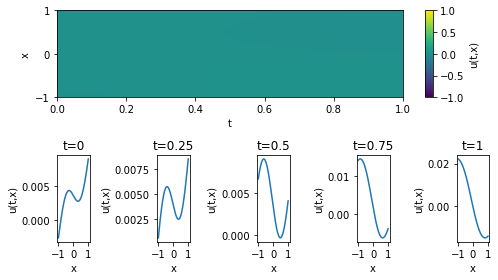

In [9]:
num_test_samples = 1000
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u = pinn_model.network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)

# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 5)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u)
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0,0.25, 0.5,0.75,1]
for i, t_cs in enumerate(t_cross_sections):
  plt.subplot(gs[1, i])
  tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
  u = pinn_model.network.predict(tx, batch_size=num_test_samples)
  plt.plot(x_flat, u)
  plt.title('t={}'.format(t_cs))
  plt.xlabel('x')
  plt.ylabel('u(t,x)')
plt.tight_layout()
plt.show()